## Imports

In [1]:
# Basic imports
import pandas as pd
import numpy as np

# Warnings
import warnings 
warnings.simplefilter("ignore")

In [2]:
# Plot
from IPython import display
import seaborn as sns

import matplotlib
import matplotlib.pylab as plt
from jupyterthemes import jtplot

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

## Data Reading

In [3]:
# Data Reading
df_train = pd.read_csv('./data/train.csv', index_col='Id')
df_test = pd.read_csv('./data/test.csv', index_col='Id') 

# Split X_train, y_train
target = 'SalePrice'
features = df_test.columns

y_train = df_train[target]
df_train = df_train[features]

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Preprocessing

In [4]:
from robusta.preprocessing.category import *
from robusta.preprocessing.numeric import *
from robusta.preprocessing.base import *
from robusta.pipeline import *

data_prep = make_pipeline(
    ColumnSelector(columns=features),
    FeatureUnion([
        ("numeric", make_pipeline(
            TypeSelector(np.number),
            Imputer(strategy="median"),
            GaussRank(),
        )),
        ("category", make_pipeline(
            TypeSelector("object"),
            Imputer(strategy="most_frequent"),
            LabelEncoder(),
            TypeConverter('category'),
        )),
    ])
)

X_train = data_prep.fit_transform(df_train)
X_test = data_prep.transform(df_test)

X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,0.233308,-0.257670,-0.273117,0.443482,-0.288640,0.584800,0.423591,0.572076,0.471615,-0.101106,...,1,1,4,4,2,2,2,2,8,4
2,-0.654032,0.551737,0.045557,-0.005474,1.248297,0.054685,-0.268858,-0.374993,0.784685,-0.101106,...,1,1,4,4,2,2,2,2,8,4
3,0.233308,-0.183035,0.412563,0.443482,-0.288640,0.494613,0.353446,0.471615,0.121388,-0.101106,...,1,1,4,4,2,2,2,2,8,4
4,0.487486,-0.460667,0.018212,0.443482,-0.288640,-1.205004,-0.396922,-0.374993,-0.181024,-0.101106,...,5,2,4,4,2,2,2,2,8,0
5,0.233308,0.660525,0.895264,0.913711,-0.288640,0.461053,0.256459,0.964415,0.371504,-0.101106,...,1,1,4,4,2,2,2,2,8,4


## Fold Preparation

In [5]:
from robusta.outliers import *

detector = IsolationForest()

encoder = FeatureUnion([
    ('category', make_pipeline(
        TypeSelector(['category', 'object']), 
        TargetEncoderCV(cv=4).set_params(encoder__smoothing=200.0),
        Imputer(strategy="mean"),
    )),
    ('numeric', make_pipeline(
        TypeSelector(np.number),
        Identity(),
    )),
])

fold_pipe = make_pipeline(encoder, detector)

F_train, _ = fold_pipe.fit_resample(X_train, y_train)
F_train

/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,181292.643105,185712.810866,181487.700984,163850.232880,225944.662916,182499.878789,200725.671882,186155.246872,184461.222009,181169.202046,...,0.337092,-0.452825,0.408970,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,-1.241331,0.090523
2,181292.643105,185712.810866,181487.700984,228631.394330,167479.380715,182499.878789,200725.671882,186155.246872,158799.399830,181169.202046,...,-0.076632,1.033547,-0.534159,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,-0.356521,-0.361037
3,181292.643105,185712.810866,181487.700984,188118.032475,225944.662916,182499.878789,200725.671882,186155.246872,184461.222009,181169.202046,...,0.565366,-0.452825,0.202436,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,0.693552,0.090523
4,181292.643105,185712.810866,199208.863734,163850.232880,167479.380715,182499.878789,141856.030435,186155.246872,184461.222009,181169.202046,...,0.648739,-0.452825,0.099880,1.718785,-0.013962,-0.069919,-0.003642,-0.030967,-1.241331,-1.131232
5,181292.643105,185712.810866,181487.700984,198813.985049,225944.662916,182499.878789,200725.671882,186155.246872,184461.222009,181169.202046,...,1.097768,0.594252,0.602937,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,4.320005,0.090523
6,181292.643105,185712.810866,181487.700984,163850.232880,225944.662916,182499.878789,200725.671882,186155.246872,184461.222009,181169.202046,...,0.013962,0.061994,0.056512,-0.126319,2.118156,-0.069919,-0.003642,1.620540,0.870568,0.596492
7,181292.643105,185712.810866,181487.700984,198813.985049,225944.662916,182499.878789,270186.353714,186155.246872,184461.222009,181169.202046,...,0.641377,0.887204,0.372898,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,0.524039,-0.361037
11,181292.643105,185712.810866,181487.700984,163850.232880,159770.999058,182499.878789,141856.030435,186155.246872,184461.222009,181169.202046,...,-0.373596,-0.452825,-0.534159,-0.126319,-0.013962,-0.069919,-0.003642,-0.030967,-1.241331,0.090523
13,181292.643105,185712.810866,181487.700984,163850.232880,167479.380715,182499.878789,141856.030435,186155.246872,184461.222009,181169.202046,...,-0.434350,0.308126,-0.534159,-0.126319,-0.013962,1.220863,-0.003642,-0.030967,0.693552,0.090523


## Model

In [6]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()

/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
%%time
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

rmsle = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
scoring = make_scorer(rmsle, greater_is_better=False)
cv = 5

rmsle_scores = lambda y_true, y_pred: -np.abs(np.log1p(y_true) - np.log1p(y_pred))
super_detector = lambda estimator: make_pipeline(
    SupervisedOutlierDetector(estimator, rmsle_scores, -0.2), 
    estimator)

trans_target = lambda estimator: TransformedTargetRegressor(estimator, np.log1p, np.expm1)

CPU times: user 26 µs, sys: 11 µs, total: 37 µs
Wall time: 39.8 µs


In [8]:
from robusta.crossval import crossval_score

crossval_score(model, cv, X_train, y_train, scoring='neg_mean_squared_error')

[22:16:12] neg_mean_squared_error: -787741049.5660 ± 285055707.1885 (LGBM)


,neg_mean_squared_error
0,-4.982058e+08
1,-1.081320e+09
2,-8.895550e+08
3,-4.711469e+08
4,-9.984772e+08


[22:16:17] iter: 1/200      neg_mean_squared_error: -0.0162      best: -0.0162 (*)   eta: 9 min 36 sec
	 {'n_estimators': 1100, 'max_depth': 8, 'num_leaves': 255, 'bagging_fraction': 0.55, 'feature_fraction': 0.55, 'learning_rate': 0.1}

[22:16:21] iter: 2/200      neg_mean_squared_error: -0.0163      best: -0.0162       eta: 9 min 43 sec
	 {'n_estimators': 900, 'max_depth': 8, 'num_leaves': 511, 'bagging_fraction': 0.45, 'feature_fraction': 0.8, 'learning_rate': 0.1}

[22:16:25] iter: 3/200      neg_mean_squared_error: -0.0163      best: -0.0162       eta: 9 min 30 sec
	 {'n_estimators': 2000, 'max_depth': 4, 'num_leaves': 31, 'bagging_fraction': 0.7, 'feature_fraction': 0.5, 'learning_rate': 0.1}



LGBMRegressor(bagging_fraction=0.55, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.55,
       importance_type='split', learning_rate=0.1, max_depth=8,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1100, n_jobs=1, num_leaves=255, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

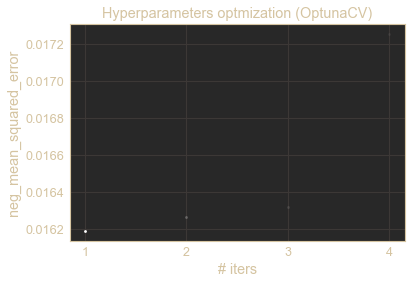

In [9]:
from robusta.optimizer import OptunaCV, RandomSearchCV

param_space = {
    'learning_rate': 0.1,
    # Once your learning rate is fixed, do not change it.

    'n_estimators': (100, 2000, 100),
    
    'max_depth': (3, 12, 1),
    'num_leaves': {15, 31, 63, 127, 255, 511, 1023, 2047, 4095},
    
    'bagging_fraction': (0.1, 0.9, 0.05),
    'feature_fraction': (0.1, 0.9, 0.05),
    
    #'lambda_l1': (1e-6, 1e6, 'log'),
    #'lambda_l2': (1e-6, 1e6, 'log'),
}

opt = OptunaCV(model, cv, 'neg_mean_squared_error', param_space, verbose=2, plot=True,
               warm_start=True, n_trials=200)

opt.fit(X_train, np.log(y_train))
opt.best_estimator_

In [ ]:
param_space = {
    #'learning_rate': 0.1,
    # Once your learning rate is fixed, do not change it.

    #'n_estimators': (100, 2000, 100),
    
    #'max_depth': (3, 12, 1),
    #'num_leaves': {15, 31, 63, 127, 255, 511, 1023, 2047, 4095},
    
    'bagging_fraction': (0.1, 0.9, 0.05),
    'feature_fraction': (0.1, 0.9, 0.05),
    
    #'lambda_l1': (1e-6, 1e6, 'log'),
    #'lambda_l2': (1e-6, 1e6, 'log'),
}

opt.set_params(param_space=param_space, n_trials=None, timeout=30, verbose=2)
opt.fit(X_train, np.log(y_train))
opt.best_estimator_

In [ ]:
from itertools import combinations

for k in range(4):
    for modules in combinations(['detector', 'trans', 'encoder'], k):
        estimator = model
        if 'encoder' in modules:
            estimator = make_pipeline(encoder, estimator) 
        if 'trans' in modules:
            estimator = trans_target(estimator)
        if 'detector' in modules:
            estimator = super_detector(estimator)
        
        scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring=scoring)
        pipe_string = ' + '.join(modules + ('model',))
        print('{:.4f} ± {:.4f} [{}]'.format(np.mean(scores), np.std(scores), pipe_string))

In [ ]:
best_estimator = trans_target(model)

## Submit (Out-of-Fold & Test Predictions)

In [ ]:
%%time
from sklearn.model_selection import cross_val_predict

y_oof = cross_val_predict(best_estimator, X_train, y_train, cv=cv)

y_oof = pd.Series(y_oof, index=X_train.index, name=target)
print(y_oof.head())

In [ ]:
%%time
from sklearn.model_selection import cross_validate

scores = cross_validate(best_estimator, X_train, y_train, cv=cv, return_estimator=True)
y_subs = [estimator.predict(X_test) for estimator in scores['estimator']]
y_sub = np.mean(y_subs, axis=0)

y_sub = pd.Series(y_sub, index=X_test.index, name=target)
print(y_sub.head())

In [ ]:
import os

path = os.path.join(os.getcwd(), 'pred')
if not os.path.exists(path):
    os.mkdir(path)

sub_path = os.path.join(path, '0 sub baseline.csv')
oof_path = os.path.join(path, '0 oof baseline.csv')

y_sub.to_csv(sub_path, header=True)
y_oof.to_csv(oof_path, header=True)

### Score:
### `[CV] 0.1282 ± 0.0074`
### `[LB] 0.1373`